## Part 1

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('./speed_data.csv', parse_dates=['hour_read_at'], infer_datetime_format=True)
df['date'] = df['hour_read_at'].dt.normalize()
df.head()

,device_id_time,network_name_mapped,test_type,download_speed,country,hour_read_at,date
0,user0,Network1,automatic,19.393999,USA,2017-07-22 07:00:00,2017-07-22
1,user0,Network1,automatic,20.850000,USA,2017-08-26 15:00:00,2017-08-26
2,user0,Network1,automatic,22.146999,USA,2017-08-31 15:00:00,2017-08-31
3,user0,Network1,automatic,17.608999,USA,2017-08-16 06:00:00,2017-08-16
4,user0,Network1,automatic,25.364000,USA,2017-07-12 07:00:00,2017-07-12


In [9]:
df_daily_speed_1 = df.pivot_table(index='date', 
                                  columns='network_name_mapped', 
                                  values='download_speed')
df_daily_speed_1.columns = pd.MultiIndex.from_product(
    [df_daily_speed_1.columns, ['all']], names=['network_name_mapped', 'test_type'])

df_daily_speed_2 = df.pivot_table(index='date', 
                                  columns=['network_name_mapped', 'test_type'], 
                                  values='download_speed')
df_daily_speed = pd.concat([df_daily_speed_1, df_daily_speed_2], axis=1)

networks = list(df_daily_speed.columns.levels[0])
df_daily_speed = df_daily_speed[pd.MultiIndex.from_product([networks, ['automatic', 'manual', 'all']])]
df_daily_speed

network_name_mapped   Network1                         Network2             \
test_type            automatic     manual        all  automatic     manual   
date                                                                         
2017-01-01           15.404101   3.354000  14.686833   7.768000   3.237800   
2017-01-02           21.476837  18.613436  21.207792   9.534631   8.381938   
2017-01-03           21.560866  24.532183  21.802065  10.637897   9.951994   
2017-01-04           21.145300  19.591819  20.994804  11.966075  11.266545   
2017-01-05           22.152335  20.047479  21.956915  10.597833   7.907578   
...                        ...        ...        ...        ...        ...   
2017-08-27           16.618623  12.080513  15.422499  11.536510  19.446585   
2017-08-28           18.136839  13.937754  17.199145  12.467090  18.161640   
2017-08-29           17.069146  15.812233  16.748232  12.123170  19.072609   
2017-08-30           18.394833  14.465702  17.426786  12.399099  20.543784   
2017-08-31           17.629559  13.602168  16.714243  11.121202  16.057190   

network_name_mapped              Network3                         Network4  \
test_type                  all  automatic     manual        all  automatic   
date                                                                         
2017-01-01            6.575842  20.117000  37.366001  24.429250        NaN   
2017-01-02            9.221554  33.520184  27.238500  31.573746  17.309524   
2017-01-03           10.467390  29.512906  31.872699  30.111163  29.500267   
2017-01-04           11.751159  31.639788  32.687896  32.023242  33.346077   
2017-01-05            9.891842  32.998448  36.539453  34.214990  28.115900   
...                        ...        ...        ...        ...        ...   
2017-08-27           14.684231  30.342679  32.231506  31.081785  20.710900   
2017-08-28           14.387474  35.588551  23.089398  29.477854  27.459880   
2017-08-29           15.434098  35.016442  38.856856  36.503054  29.384971   
2017-08-30           16.844118  35.975456  36.068350  36.010565  18.523550   
2017-08-31           13.156847  33.063190  38.095886  35.626426  32.060552   

network_name_mapped                        
test_type               manual        all  
date                                       
2017-01-01           20.754999  20.754999  
2017-01-02           21.878015  20.279043  
2017-01-03           30.507000  30.147452  
2017-01-04           27.499996  28.990173  
2017-01-05           29.548279  28.975327  
...                        ...        ...  
2017-08-27           19.859032  20.174539  
2017-08-28           41.402504  39.109309  
2017-08-29           37.371508  34.807024  
2017-08-30           40.981797  38.415140  
2017-08-31           49.162588  44.849900  

[243 rows x 12 columns]

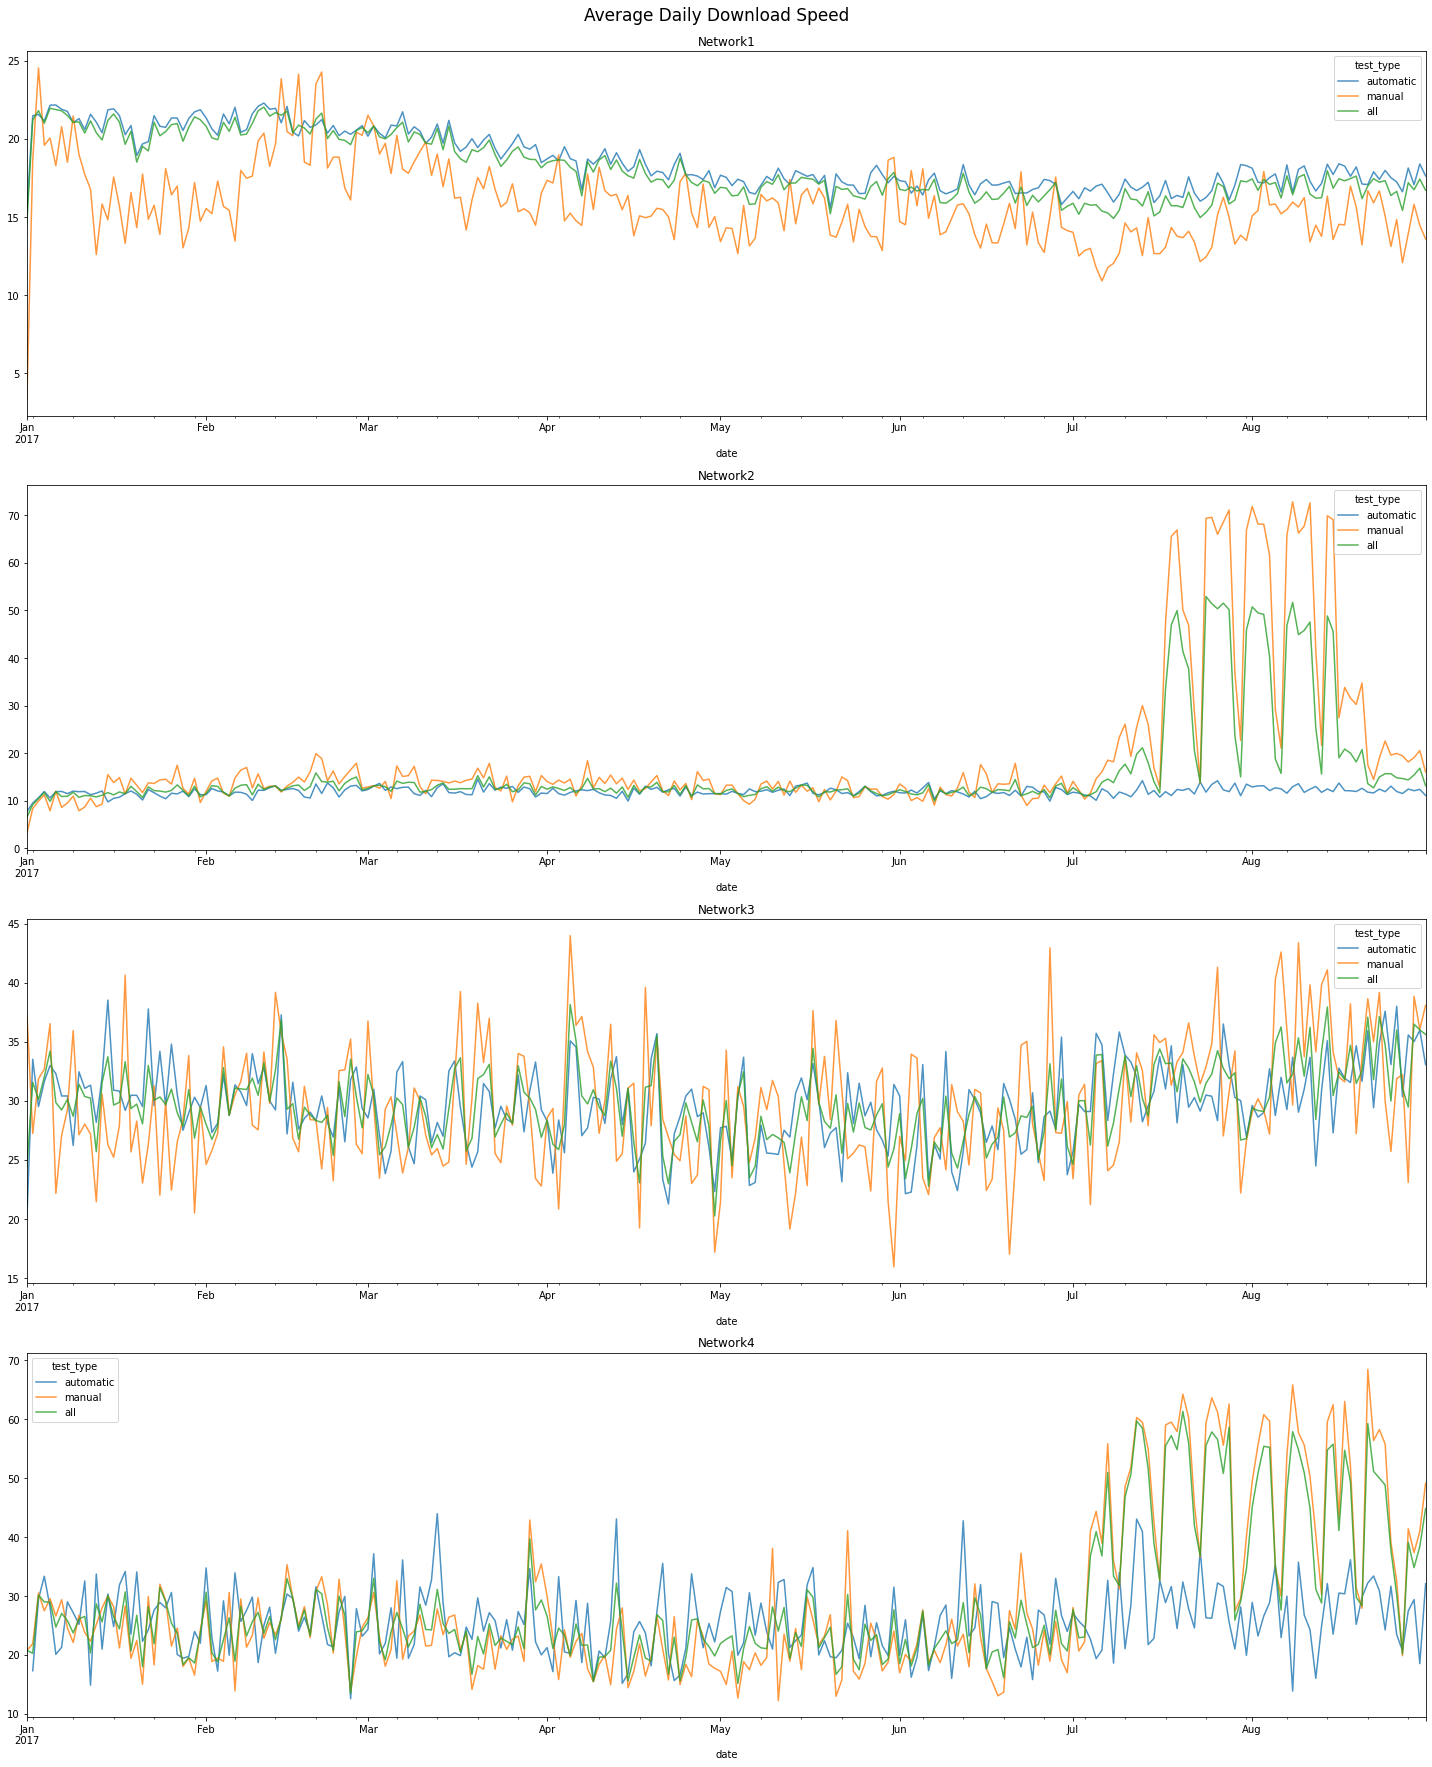

In [10]:
import matplotlib.pyplot as plt

fig_daily, axes_daily = plt.subplots(4, 1, figsize=(20, 25))
fig_daily.suptitle('Average Daily Download Speed', fontsize=17)
axes_daily = axes_daily.flatten()

for i, nw in enumerate(networks):
    ax = axes_daily[i]
    ax.set_title(nw)
    df_daily_speed[nw].plot(ax=ax, alpha=0.8)
    
fig_daily.tight_layout(rect=[0, 0, 1, 0.97])

As shown by the plot above, the daily download speed of manual tests is more fluctuating than that of the automatic tests. 

This is testified by the standard deviation as follows, which indicates that automatic tests of all 4 networks are much lower than that of the manual.

In [11]:
df_daily_speed.std(axis=0)

network_name_mapped  test_type
Network1             automatic     1.815754
                     manual        2.563978
                     all           1.954982
Network2             automatic     0.910473
                     manual       15.580120
                     all          10.106172
Network3             automatic     3.429730
                     manual        5.333205
                     all           3.160847
Network4             automatic     5.832245
                     manual       13.508445
                     all          11.217856
dtype: float64

The differences in the std of the daily mean time series is due to the biased daily volume and user sample set of the manual tests, as opposed to that of the automatic tests which collect samples randomly - probability of collection equal in both time and user respects.
- For days with low/no manual tests volume, the sample mean may not be a good estimate of the actual mean
- The samples by user is imbalanced. For days with high manual tests volume, the sample mean could be skewed by specific users in particular network situations who run the most tests
- The sample set may not cover all users, if only some users would manually test their network, while almost of others wouldn't

In [12]:
volumes_type = df.pivot_table(index=['date', 'device_id_time'], 
                              columns=['network_name_mapped', 'test_type'], 
                              values='download_speed', 
                              aggfunc='count')
volumes_auto = volumes_type.xs('automatic', axis=1, level='test_type')
volumes_man = volumes_type.xs('manual', axis=1, level='test_type')
volumes_all = (volumes_auto.fillna(0) + volumes_man.fillna(0)).replace(0, np.nan)
volumes_all.columns = pd.MultiIndex.from_product(
    [volumes_all.columns, ['all']], names=['network_name_mapped', 'test_type'])

volumes = pd.concat([volumes_type, volumes_all], axis=1)
volumes = volumes[volumes.columns.sortlevel()[0]]
daily_vol_per_device = volumes.groupby(level='date').mean()
daily_vol_per_device

network_name_mapped  Network1                      Network2            \
test_type                 all automatic    manual       all automatic   
date                                                                    
2017-01-01           1.012048  1.000000  1.250000  1.000000  1.000000   
2017-01-02           1.064793  1.028441  1.510791  1.094595  1.020761   
2017-01-03           1.063640  1.023383  1.798450  1.139485  1.015267   
2017-01-04           1.084477  1.036298  1.814815  1.163551  1.014706   
2017-01-05           1.055699  1.024007  1.436709  1.140590  1.027701   
...                       ...       ...       ...       ...       ...   
2017-08-27           1.134808  1.008900  1.622857  1.194581  1.000000   
2017-08-28           1.111584  1.015573  1.581325  1.168565  1.021021   
2017-08-29           1.141429  1.007905  1.723944  1.400943  1.006472   
2017-08-30           1.113464  1.010322  1.532394  1.615591  1.007380   
2017-08-31           1.094527  1.002950  1.501502  1.274419  1.000000   

network_name_mapped            Network3                      Network4  \
test_type              manual       all automatic    manual       all   
date                                                                    
2017-01-01           1.000000  1.000000  1.000000  1.000000  1.000000   
2017-01-02           1.309524  1.136000  1.020833  1.466667  1.463415   
2017-01-03           1.650000  1.100775  1.029126  1.333333  1.400000   
2017-01-04           1.663043  1.197080  1.029703  1.666667  1.758621   
2017-01-05           1.571429  1.189781  1.028846  1.555556  1.562500   
...                       ...       ...       ...       ...       ...   
2017-08-27           1.678261  1.254545  1.024390  1.928571  1.327869   
2017-08-28           1.530973  1.350000  1.014706  1.941176  2.338462   
2017-08-29           2.378151  1.192308  1.000000  1.578947  1.557143   
2017-08-30           3.094340  1.209524  1.000000  1.600000  2.916667   
2017-08-31           1.931624  1.352941  1.025974  1.863636  1.691176   

network_name_mapped                      
test_type           automatic    manual  
date                                     
2017-01-01                NaN  1.000000  
2017-01-02           1.000000  1.857143  
2017-01-03           1.000000  1.687500  
2017-01-04           1.000000  2.375000  
2017-01-05           1.052632  2.307692  
...                       ...       ...  
2017-08-27           1.034483  1.593750  
2017-08-28           1.000000  2.822222  
2017-08-29           1.029412  1.947368  
2017-08-30           1.000000  3.780488  
2017-08-31           1.000000  2.000000  

[243 rows x 12 columns]

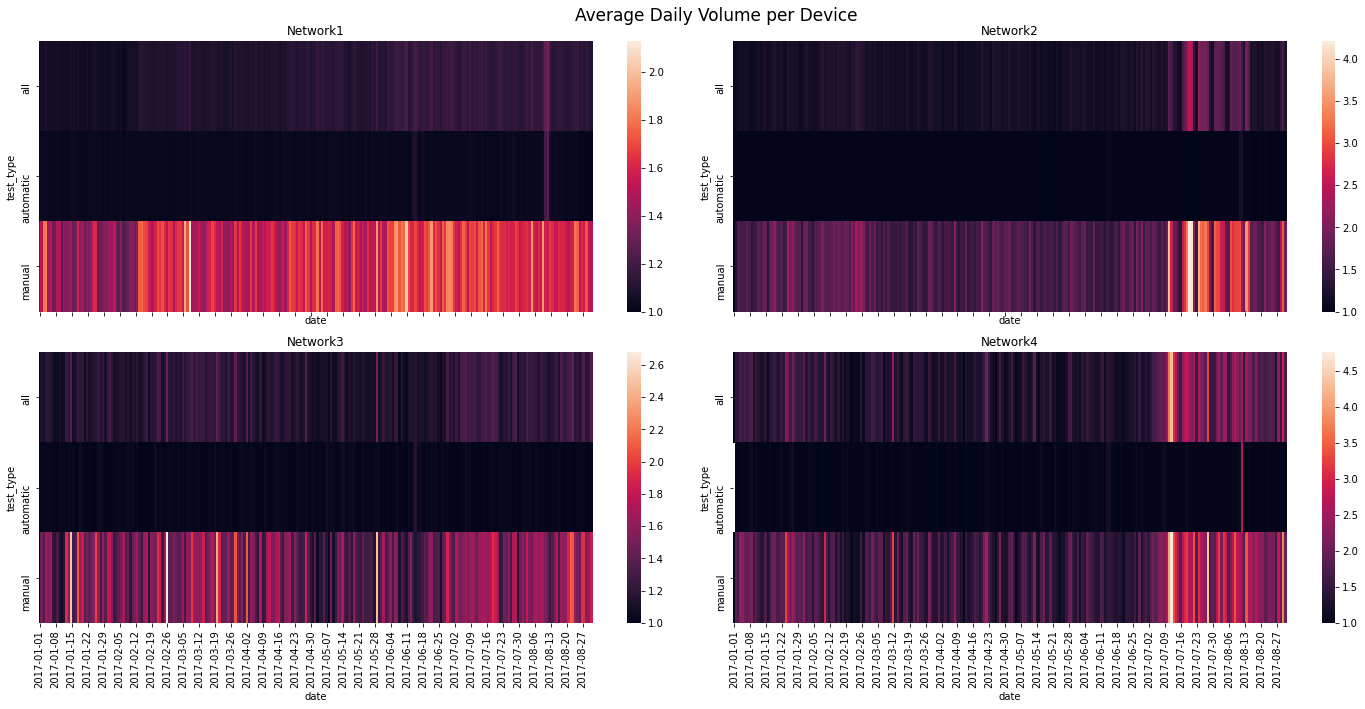

In [14]:
import seaborn as sns

fig_vol, axes_vol = plt.subplots(2, 2, figsize=(20, 10), sharex=True)
fig_vol.suptitle('Average Daily Volume per Device', fontsize=17)
axes_vol = axes_vol.flatten()

for i, nw in enumerate(networks):
    ax = axes_vol[i]
    ax.set_title(nw)
    sns.heatmap(daily_vol_per_device[nw].T, ax=ax)
    xtick_labels = pd.DatetimeIndex(x.get_text() for x in ax.get_xticklabels()).strftime('%Y-%m-%d')
    ax.set_xticklabels(xtick_labels)
    
fig_vol.tight_layout(rect=[0, 0, 1, 0.97])

Denote that: 

$ ADV $ = average daily volume per device (derived by the total daily test volume divided by the number of unique devices)

$ ADS $ = average daily download speed


As is seen from the figure above, the $ ADV $ of automatic tests is rather evenly distributed, while that of the manual tests varies from time to time.

And it appears that on days where manual $ ADV $ deviates from its mean, the $ ADS $ diverges significantly as well, which suggests the manual daily speed of the day is likely skewed by the abnormal user behaviours.

Let's plot the absolute difference between manual $ ADV $ and all $ ADV $ mean together with $ ADS $ on the same timeline to get a better view.

In [15]:
df_vol_man = daily_vol_per_device.xs('manual', axis=1, level='test_type')
df_vol_all = daily_vol_per_device.xs('all', axis=1, level='test_type')
df_diff = (df_vol_man - df_vol_all.mean(axis=0)).abs()

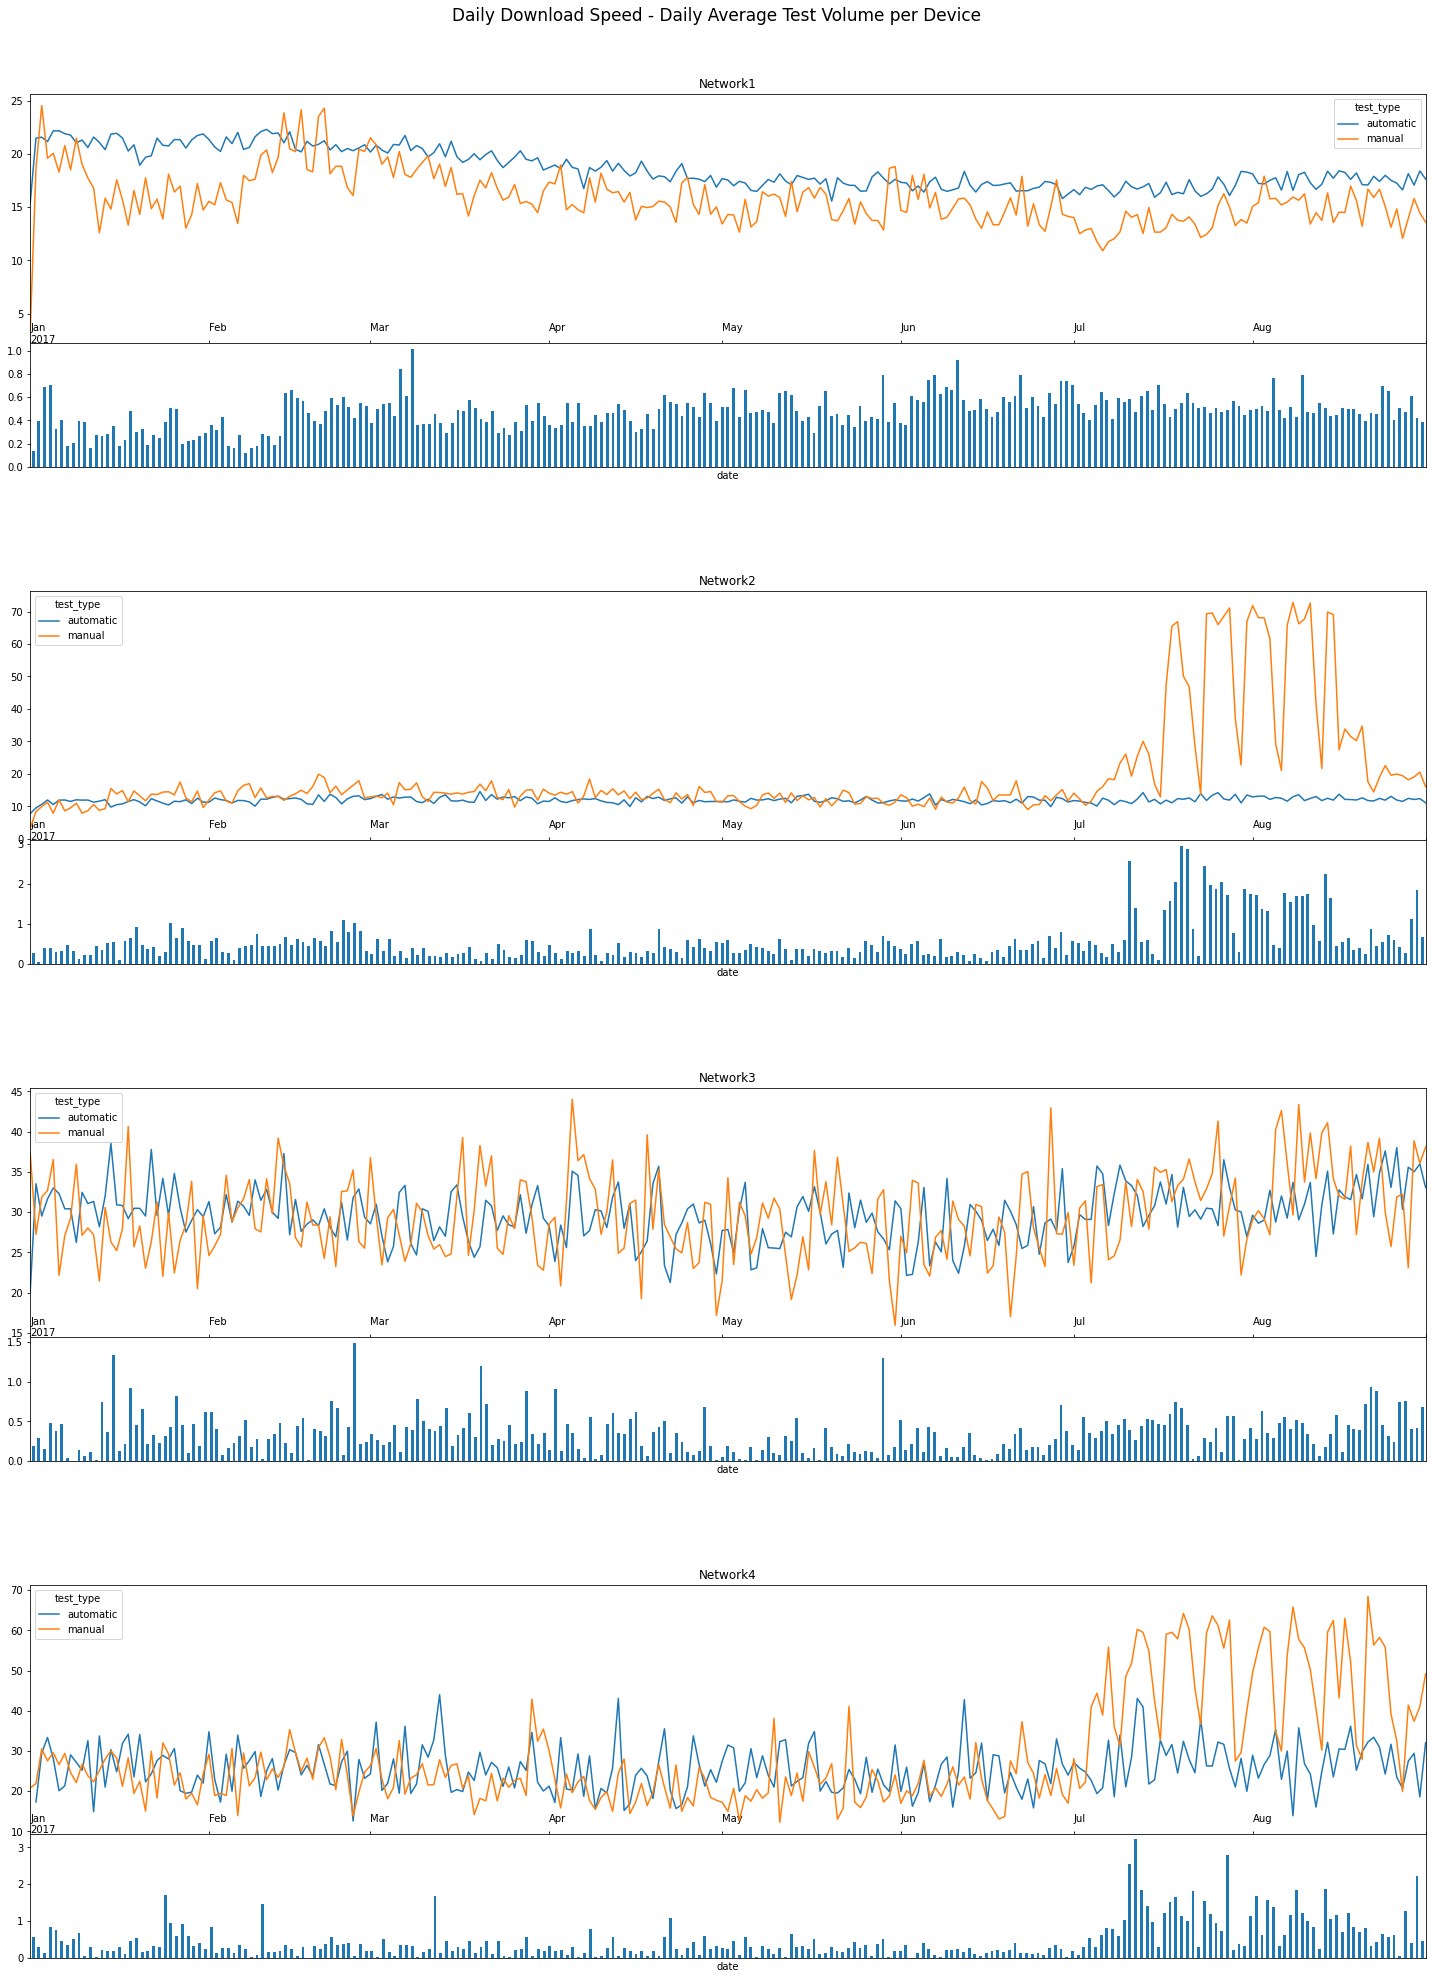

In [16]:
fig_com = plt.figure(figsize=(20, 28))
fig_com.suptitle('Daily Download Speed - Daily Average Test Volume per Device', fontsize=17)
grid = (3 * 4 + 3, 1)
for i, nw in enumerate(networks):
    nrow = 4 * i
    ax1 = plt.subplot2grid(grid, (nrow, 0), rowspan=2)    
    ax1.set_title(nw)
    ax1.tick_params(axis="x", direction="in", pad=-20)
    df_daily_speed[nw][['automatic', 'manual']].plot(ax=ax1)
    plt.setp(ax1.get_xticklabels(), horizontalalignment='left')
    
    ax2 = plt.subplot2grid(grid, (nrow + 2, 0), rowspan=1)
    ax2.tick_params(axis='x', bottom=False, labelbottom=False)
    df_diff[nw].plot(ax=ax2, kind='bar')
    
fig_com.tight_layout(rect=[0, 0, 1, 0.95], h_pad=0)
plt.subplots_adjust(hspace=0)

The distribution of the $ ADV $ of manual tests may be reflecting the posteriori probabilies of the network speed in cetain state of the participant users, other than a general knowledge of the network. The results could be highly dependent on the user behaviours factored in which may(or not) be the edge cases. For example:
- Users may only want to test the speed when they figure there is a unusual performance - the network being too slow or surprisingly fast. This could be affected by the signal or the environment, or that each one has a different perception of the unusual associated with their usage.
- There may be a correlation between the test speed and time - at certain time the network speed is generally faster than the others, and/or users tend to run tests during daytime when they are active.
- A user or group of users may run frequent tests a day if they experience an abnormal network, and this would largely impacted the daily tested speed.



## Part 2

The proposed method is a low-pass filter.

The basic idea behind it, is to make use of the rolling average computed based on the last W observations of download speed (where W is a sliding window of fixed size), as a means to identify anomalies. The rolling average is calculated from automatic tests.

Specifically, new observations of manual test that differ too much from the rolling average, are registered as anomalous events.

Initialize:

>$ X $ ← {$ x_{1} $ , … , $ x_{n} $ }

>$ W $ ← window_size

>$ std $ ← std($ X $)

>$ w_{i} $ ← the rolling average of previous sample vector of size $ W $ at $ x_{i} $



Algorithm:

foreach $ x_{i} $ in $ X $ do:

if ($ x_{i} $ · α > $ w_{i} $ + $ std $) OR (($ x_{i} $ · α < $ w_{i} $ - $ std $)):
 
register_anomaly($ x_{i} $)

In [17]:
window_size = 10
df_srt = df.sort_values(['hour_read_at', 'test_type']).reset_index(drop=True)
mv_avg_dfs = []
for _, df_nw in df_srt.groupby('network_name_mapped'):
    is_auto = df_nw['test_type'] == 'automatic'
    df_auto = df_nw[is_auto]
    mv_avg_auto = df_auto['download_speed'].rolling(window_size, min_periods=1).mean()
    mv_avg_ffill = mv_avg_auto.reindex(df_nw.index).ffill()
    df_avg_man = df_nw.assign(mv_avg=mv_avg_ffill)[~is_auto]
    
    # fill the missing moving average of auto tests with that of the manual tests
    mv_avg_man = df_avg_man['download_speed'].rolling(window_size, min_periods=1).mean()
    df_avg_man['mv_avg'].fillna(mv_avg_man, inplace=True) 
    mv_avg_dfs.append(df_avg_man)

df_man = pd.concat(mv_avg_dfs)
df_man

,device_id_time,network_name_mapped,test_type,download_speed,country,hour_read_at,date,mv_avg
27,user91501,Network1,manual,6.501000,USA,2017-01-01 04:00:00,2017-01-01,19.5961
63,user104498,Network1,manual,3.480000,USA,2017-01-01 17:00:00,2017-01-01,15.1502
88,user70827,Network1,manual,0.445000,USA,2017-01-01 21:00:00,2017-01-01,6.9649
89,user98663,Network1,manual,4.075500,USA,2017-01-01 21:00:00,2017-01-01,6.9649
90,user98663,Network1,manual,2.268500,USA,2017-01-01 21:00:00,2017-01-01,6.9649
...,...,...,...,...,...,...,...,...
786043,user11629,Network4,manual,22.537001,TWN,2017-08-31 16:00:00,2017-08-31,19.3958
786349,user7751,Network4,manual,13.786000,TWN,2017-08-31 18:00:00,2017-08-31,19.3958
786666,user1314,Network4,manual,57.084999,TWN,2017-08-31 20:00:00,2017-08-31,19.3958
786980,user1314,Network4,manual,66.050003,TWN,2017-08-31 22:00:00,2017-08-31,19.6983


In [35]:
# alpha is a hyper-parameter (between 0 and 1) that regulates the algorithm sensitivity to anomalies
def is_out_cflevel(data, mean, alpha=1, std_rolling=False, w_size=window_size):
    residual = data - mean
    if std_rolling:
        std = residual.rolling(w_size).std() 
        std.fillna(std.iloc[w_size - 1], inplace=True)
    else:
        std = np.std(residual)
    scaled_rsd = residual * alpha
    return (scaled_rsd > mean + std) | (scaled_rsd < mean - std)
    

In [36]:
# low-pass filter using static std of the residual
filter_dfs = []
for df_nw in mv_avg_dfs:
    mean = df_nw['mv_avg']
    df_nw['is_anomalous'] = is_out_cflevel(df_nw['download_speed'], mean)
    gb = df_nw.groupby('date')
    is_anomalous = gb.apply(lambda x: is_out_cflevel(x['download_speed'], x['download_speed'].mean()) 
                                if x['is_anomalous'].all() else x['is_anomalous'])
    is_anomalous = is_anomalous.reset_index(0, drop=True)
    df_nw['is_anomalous'] = is_anomalous
    filter_dfs.append(df_nw)

df_man = pd.concat(filter_dfs)
df_man

,device_id_time,network_name_mapped,test_type,download_speed,country,hour_read_at,date,mv_avg,is_anomalous
27,user91501,Network1,manual,6.501000,USA,2017-01-01 04:00:00,2017-01-01,19.5961,True
63,user104498,Network1,manual,3.480000,USA,2017-01-01 17:00:00,2017-01-01,15.1502,True
88,user70827,Network1,manual,0.445000,USA,2017-01-01 21:00:00,2017-01-01,6.9649,False
89,user98663,Network1,manual,4.075500,USA,2017-01-01 21:00:00,2017-01-01,6.9649,False
90,user98663,Network1,manual,2.268500,USA,2017-01-01 21:00:00,2017-01-01,6.9649,False
...,...,...,...,...,...,...,...,...,...
786043,user11629,Network4,manual,22.537001,TWN,2017-08-31 16:00:00,2017-08-31,19.3958,False
786349,user7751,Network4,manual,13.786000,TWN,2017-08-31 18:00:00,2017-08-31,19.3958,False
786666,user1314,Network4,manual,57.084999,TWN,2017-08-31 20:00:00,2017-08-31,19.3958,False
786980,user1314,Network4,manual,66.050003,TWN,2017-08-31 22:00:00,2017-08-31,19.6983,False


In [37]:
df_man_flt = df_man[~df_man['is_anomalous']]
print(f'Filtered rows from {len(df_man)} to {len(df_man_flt)}')

Filtered rows from 197786 to 101917


In [38]:
df_auto = df[df['test_type'] == 'automatic']
df_flt = pd.concat([df_auto, df_man_flt])
df_daily_flt = df_flt.pivot_table(index='date', 
                                  columns=['network_name_mapped', 'test_type'], 
                                  values='download_speed')
df_daily_flt.rename(columns={'manual': 'manual_flt'}, inplace=True)

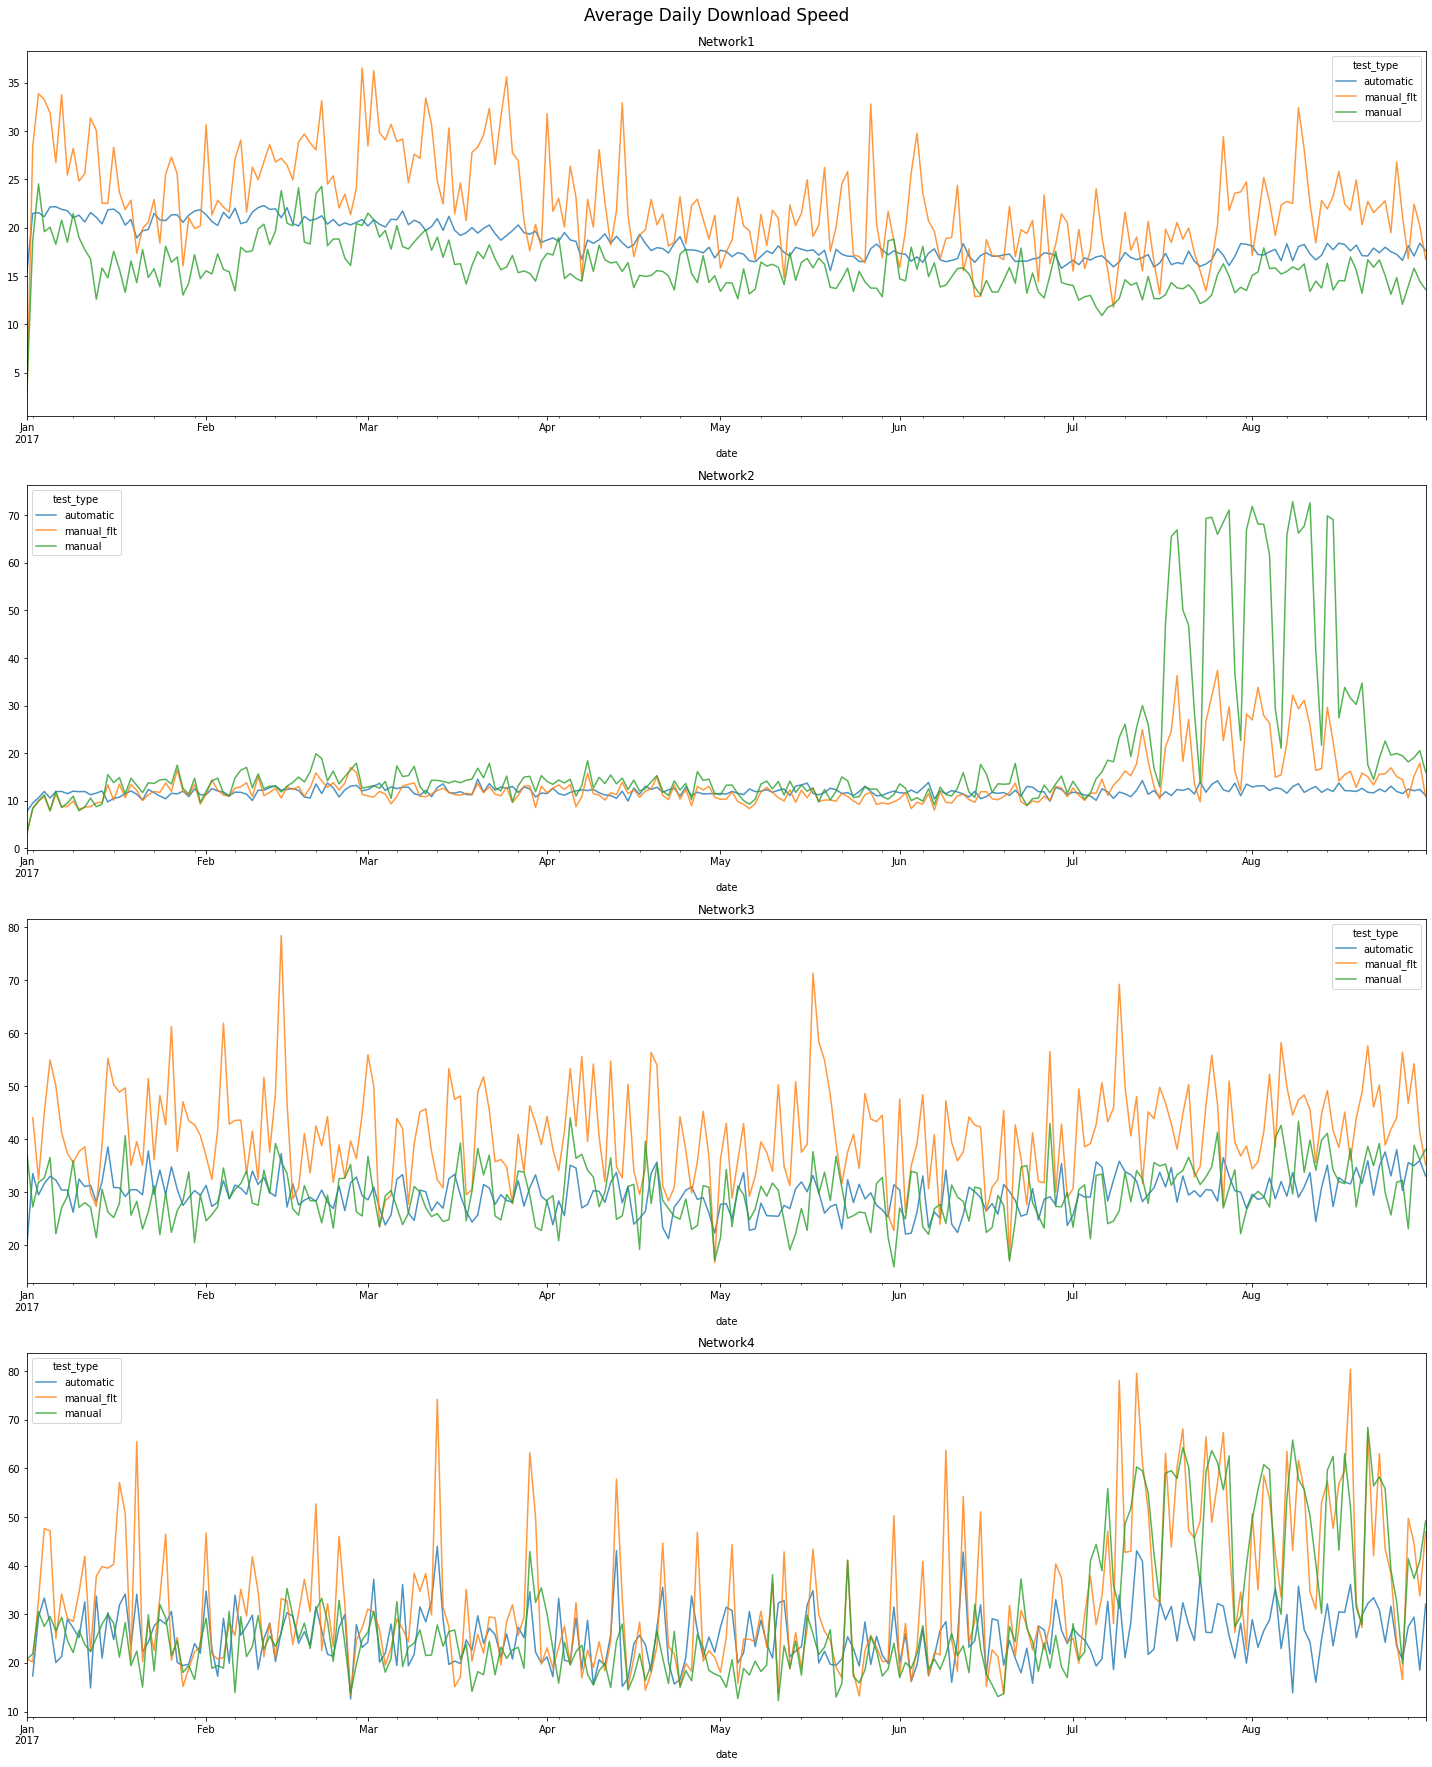

In [39]:
fig_daily_flt, axes_daily_flt = plt.subplots(4, 1, figsize=(20, 25))
fig_daily_flt.suptitle('Average Daily Download Speed', fontsize=17)
axes_daily_flt = axes_daily_flt.flatten()

for i, nw in enumerate(networks):
    ax = axes_daily_flt[i]
    ax.set_title(nw)
    df_daily_flt[nw].plot(ax=ax, alpha=0.8)
    df_daily_speed[nw][['manual']].plot(ax=ax, alpha=0.8)
    
fig_daily_flt.tight_layout(rect=[0, 0, 1, 0.97])

In [40]:
# low-pass filter using rolling std of the residual
filter_dfs_rolling = []
for df_nw in mv_avg_dfs:
    mean = df_nw['mv_avg']
    df_nw['is_anomalous'] = is_out_cflevel(df_nw['download_speed'], mean, std_rolling=True)
    gb = df_nw.groupby('date')
    is_anomalous = gb.apply(lambda x: is_out_cflevel(x['download_speed'], x['download_speed'].mean()) 
                                if x['is_anomalous'].all() else x['is_anomalous'])
    is_anomalous = is_anomalous.reset_index(0, drop=True)
    df_nw['is_anomalous'] = is_anomalous
    filter_dfs_rolling.append(df_nw)

df_man_rolling = pd.concat(filter_dfs_rolling)

In [41]:
df_man_flt_rolling = df_man_rolling[~df_man_rolling['is_anomalous']]
print(f'Filtered rows from {len(df_man_rolling)} to {len(df_man_flt_rolling)}')

Filtered rows from 197786 to 68335


In [42]:
df_flt_rolling = pd.concat([df_auto, df_man_flt_rolling])
df_daily_flt_rolling = df_flt_rolling.pivot_table(index='date', 
                                                  columns=['network_name_mapped', 'test_type'], 
                                                  values='download_speed')

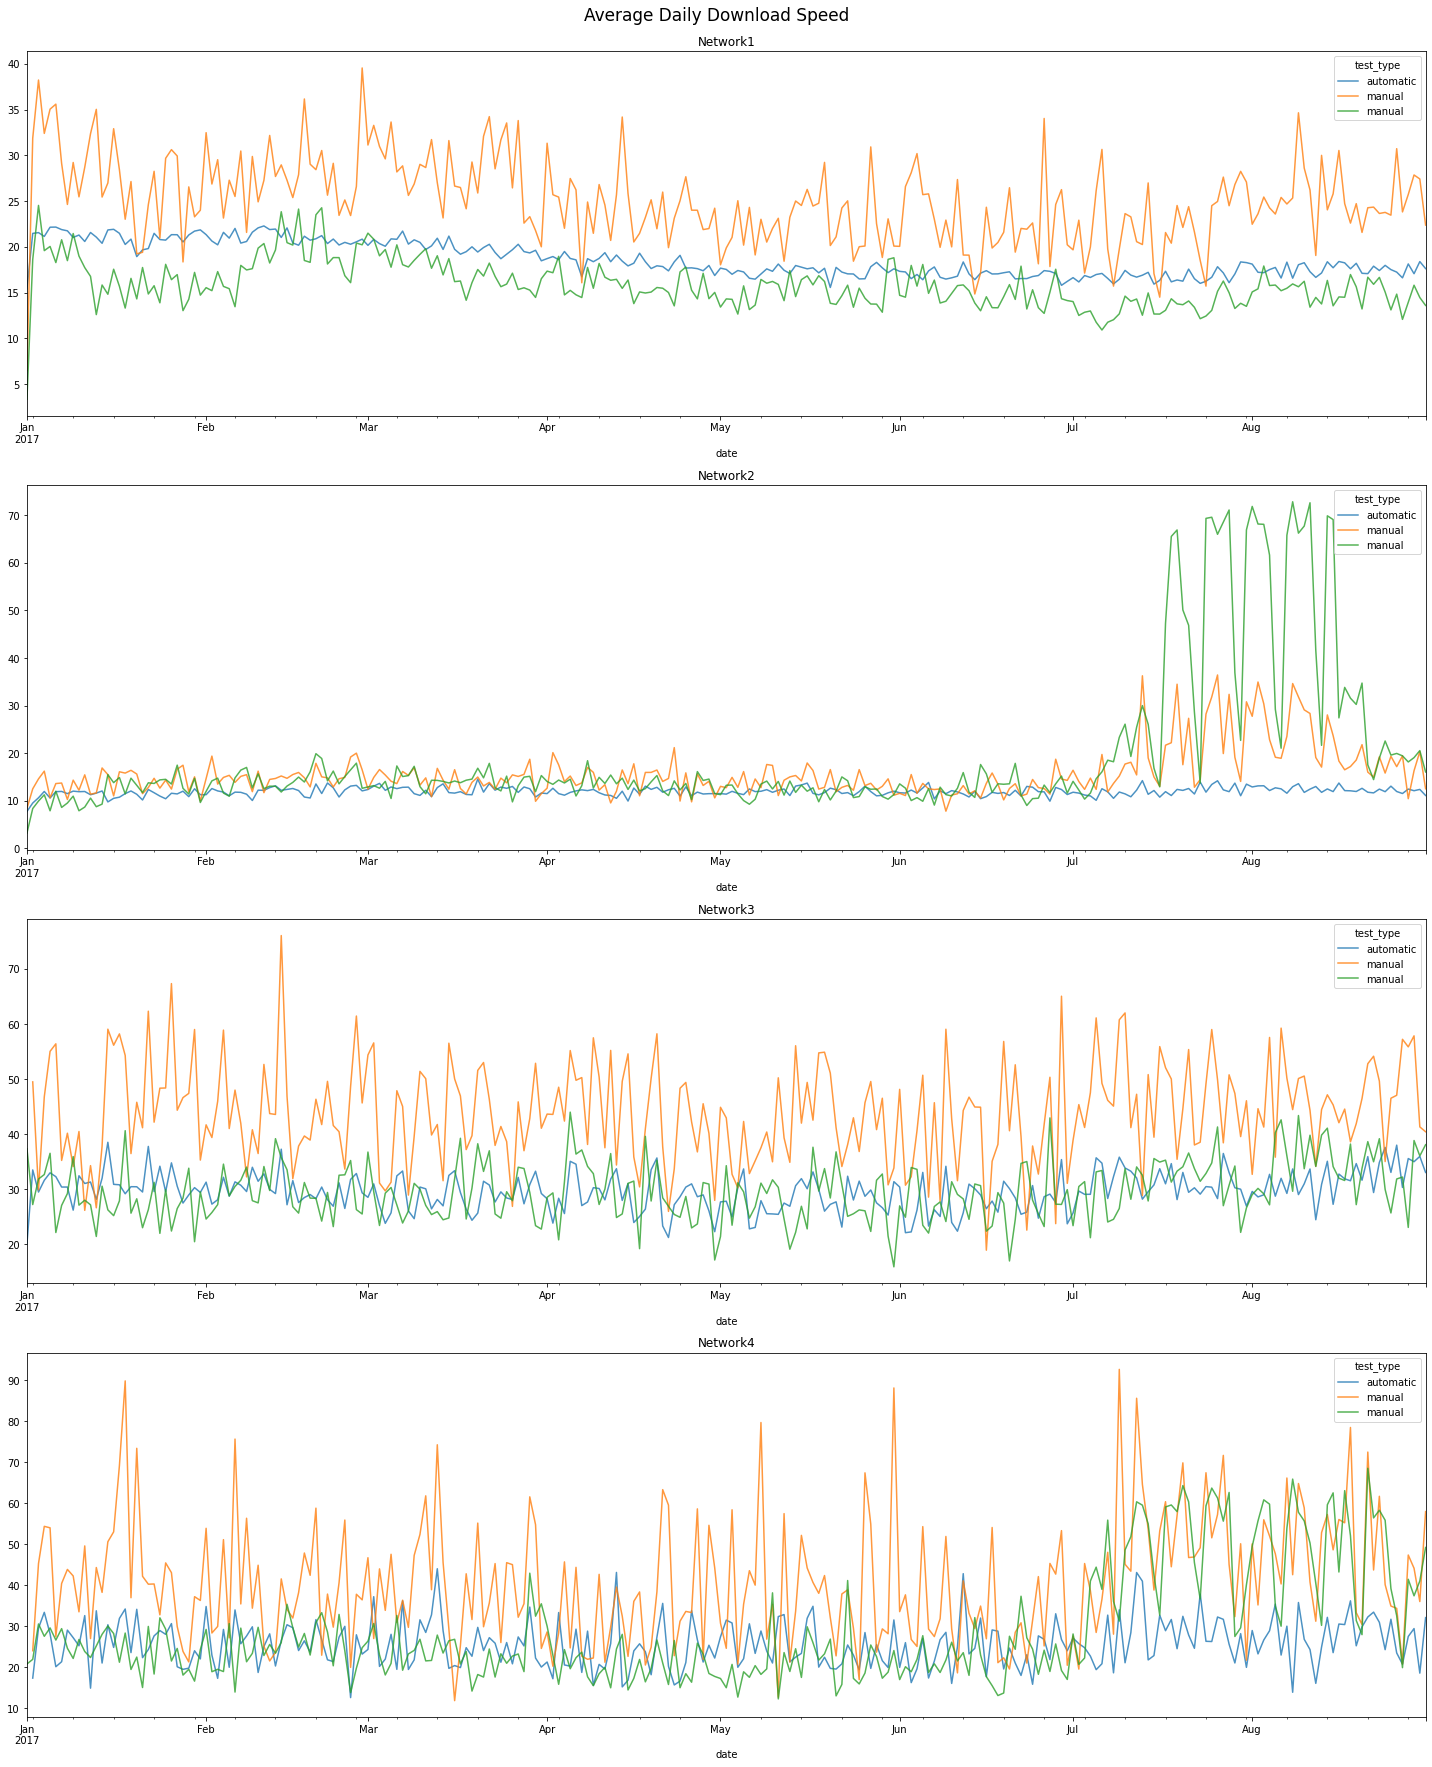

In [43]:
fig_daily_fltr, axes_daily_fltr = plt.subplots(4, 1, figsize=(20, 25))
fig_daily_fltr.suptitle('Average Daily Download Speed', fontsize=17)
axes_daily_fltr = axes_daily_fltr.flatten()

for i, nw in enumerate(networks):
    ax = axes_daily_fltr[i]
    ax.set_title(nw)
    df_daily_flt_rolling[nw].plot(ax=ax, alpha=0.8)
    df_daily_speed[nw][['manual']].plot(ax=ax, alpha=0.8)
    
fig_daily_fltr.tight_layout(rect=[0, 0, 1, 0.97])

As shown in the visualization above, the low-pass filter is good at dealing with data with stable $ ADS $ over time and relatively close rolling average of $ ADS $ between automatic and manual tests, such as the Network2 data. Because such data has a relatively small std, the filter can correctly detect the anomalies when the sample value departs one std away from the mean.

However for data that doesn't with fluctuating $ ADS $ over time (Network3, Network4) and disparate rolling average of $ ADS $ between automatic and manual tests (Network1), there may be lots of false positives and the results are not so great. Filtering out the false positives increases the $ ADS $, possibly by removing the samples triggered by extensive tests with low network speed. 

Improvements for it could be:
-  Devise an accuracy measure to evaluate the efficiency of the filter, and use it in cross validation to tune the hyperparameter α to achieve a better results
- Use multiple low-pass filters on different level: 
    * first filter the $ ADS $ on day level, based on the $ ADV $ analysis in part1, decide whether the $ ADS $ of the day is anomalous
    * if the $ ADS $ is anomalous, do a finer filtering on the user/device level, that is if the $ ADS $ of a particular device is far from the rolling average, remove the it from the samples

